In [219]:
# !pip install geopy

In [608]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.cluster import KMeans

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

In [554]:
clusters_df = pd.read_csv('clusters.csv', sep=';')
main_df = pd.read_csv('dataset.csv')

# Diving deep:

In [561]:
print("signal classes count:")
signals = clusters_df['Descrizione'].unique()
len(signals)

signal classes count:


234

In [560]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b")
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-9b",
    device_map="auto",
    torch_dtype=torch.float16
)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [566]:
signal_tokens_list = [tokenizer(signal, return_tensors='pt')['input_ids'] for signal in signals]

In [637]:
embeddings = []

with torch.no_grad():
    for signal_tokens in tqdm(signal_tokens_list):
        embeddings.append(model(signal_tokens,
                        output_hidden_states=True)['hidden_states'][0][:,-1,:])

embeddings = torch.vstack(embeddings).numpy()

  0%|          | 0/234 [00:00<?, ?it/s]

In [638]:
# Determine the number of clusters (you may need to adjust this based on your data)
num_clusters = 40  # Change this number based on your expected number of clusters

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init='auto')
clusters = kmeans.fit_predict(embeddings)

In [640]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

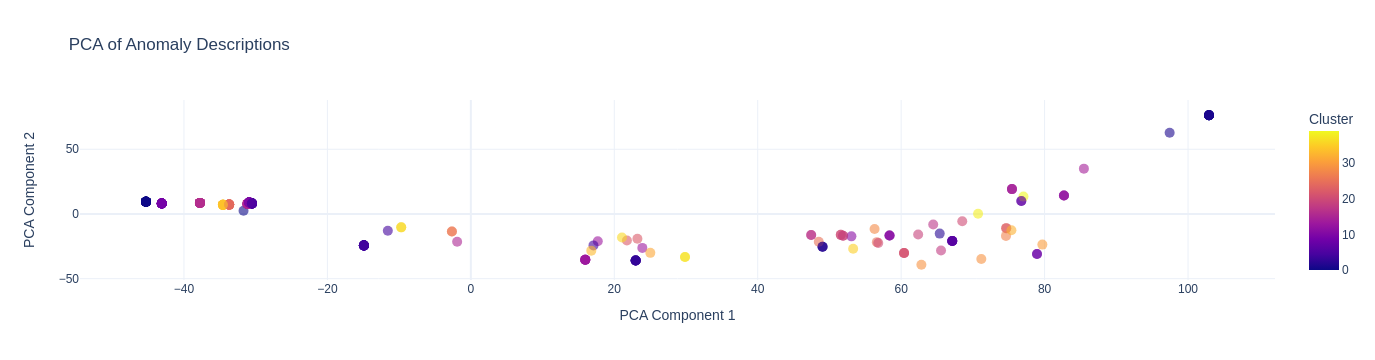

In [641]:
data = {
    'PCA1': pca_result[:, 0],
    'PCA2': pca_result[:, 1],
    'Description': signals,
    'Cluster': clusters
}

# Create the interactive plot using Plotly
fig = px.scatter(data, x='PCA1', y='PCA2',
                 hover_name='Description',
                 color='Cluster',
                 title='PCA of Anomaly Descriptions')

fig.update_traces(marker=dict(size=10, opacity=0.6))

# Customize layout for better readability
fig.update_layout(
    hovermode='closest',
    title='PCA of Anomaly Descriptions',
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    template='plotly_white'
)

# Show the interactive plot
fig.show()

In [632]:
clustered_signal_tuples = list(zip(signals, clusters))

for cluster in range(40):
    print([cs_tuple[0] for cs_tuple in clustered_signal_tuples if cs_tuple[1]==cluster])
    print('\n\n')

['Guasto microswitch porta Gangway 1', 'Perdita di comunicazione con HVAC cabina M1', 'Direzione indietro in M1', 'Piastra ERTMS inserita in M1', 'Direzione avanti in M1', 'Frenatura di emergenza attivata da leva di frenatura in M1', 'Incongruenza BRAKE_STATUS_TL e manettino di frenatura M1', 'Mancata ricezione R2 in CCU M1', 'Mancata comunicazione WTB in CCU M1', 'Perdita di comunicazione MVB con TCU M1', 'Mancata Comunicazione con LCU1', 'Livello olio basso nel compressore 1', 'Frenatura di emergenza attivata da leva di trazione in M1', 'Guasto microswitch porta interna 1', 'Chiave di Banco inserita in M1', 'Banco Abilitato M1', 'Mancata ricezione R1 in CCU M1', 'Perdita di comunicazione con HVAC M1', 'Auto esclusione convertitore M1', 'Avvio centralina BCU M1', "Incorenza sts velocita' 0 porta 1 M1", "Incorenza sts velocita' 0 porta 2 M1", 'Apertura forzata IP-IR per apertura Q1', 'Cod 03. Apertura Interruttore principale richiesto da TCU1 M1']



['Rilevata perdita nella condotta f

# Dive deep part 2:

In [644]:
min_timestamp = main_df['Timestamp'].min()
max_timestamp = main_df['Timestamp'].max()

print("Minimum Timestamp:", min_timestamp)
print("Maximum Timestamp:", max_timestamp)

Minimum Timestamp: 2022-03-07 00:18:42.369
Maximum Timestamp: 2022-03-14 14:04:24.901


In [645]:
main_df['Timestamp'] = pd.to_datetime(main_df['Timestamp'])

# Ensure the DataFrame is sorted by the timestamp column
sorted_df = main_df.sort_values('Timestamp')

# Calculate the time differences between consecutive timestamps
sorted_df['intertimes'] = sorted_df['Timestamp'].diff()

sorted_df['intertimes'] = pd.to_timedelta(sorted_df['intertimes'])

# Drop the first row since it will have NaT (Not a Time) due to the diff operation
sorted_df = sorted_df.dropna(subset=['intertimes'])

print("Intertimes Statistics:")
print(sorted_df['intertimes'].describe())

Intertimes Statistics:
count                        57651
mean     0 days 00:00:11.350063867
std      0 days 00:04:25.170344945
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max         0 days 08:16:11.655000
Name: intertimes, dtype: object


In [646]:
sorted_df['intertimes'] = sorted_df['intertimes'].apply(lambda x: \
                                          x.total_seconds() * 10**6 \
                                          + x.microseconds)

In [647]:
sorted_df['intertimes'].describe()

count    5.765100e+04
mean     1.143300e+07
std      2.651875e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.977231e+10
Name: intertimes, dtype: float64

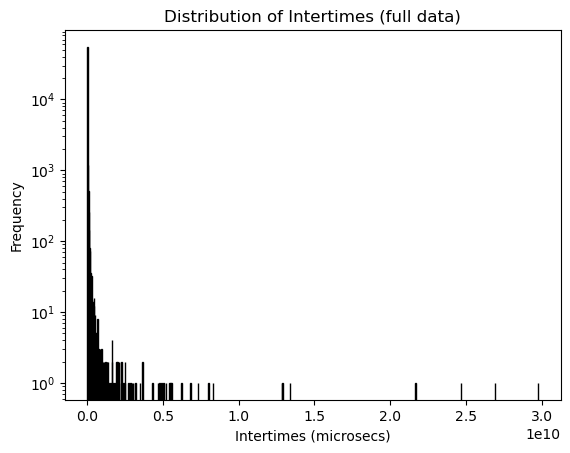

In [648]:
# Plot the histogram
plt.hist(sorted_df['intertimes'], bins=1000, edgecolor='black')
plt.xlabel('Intertimes (microsecs)')
plt.ylabel('Frequency')
# Set y-axis to log scale
plt.yscale('log')
plt.title('Distribution of Intertimes (full data)')
plt.show()

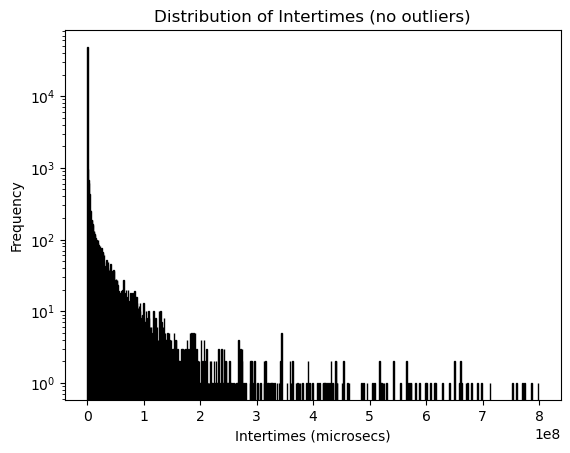

In [649]:
# Calculate the Z-scores of the series
z_scores = stats.zscore(sorted_df['intertimes'])

# Define a threshold for Z-scores to identify outliers (commonly 3 or -3)
z_score_threshold = 3

# Filter the series to remove outliers
filtered_series_zscore = sorted_df['intertimes'][(z_scores < z_score_threshold) & (z_scores > -z_score_threshold)]


# Plot the histogram
plt.hist(filtered_series_zscore, bins=1000, edgecolor='black')
plt.xlabel('Intertimes (microsecs)')
plt.ylabel('Frequency')
# Set y-axis to log scale
plt.yscale('log')

plt.title('Distribution of Intertimes (no outliers)')
plt.show()

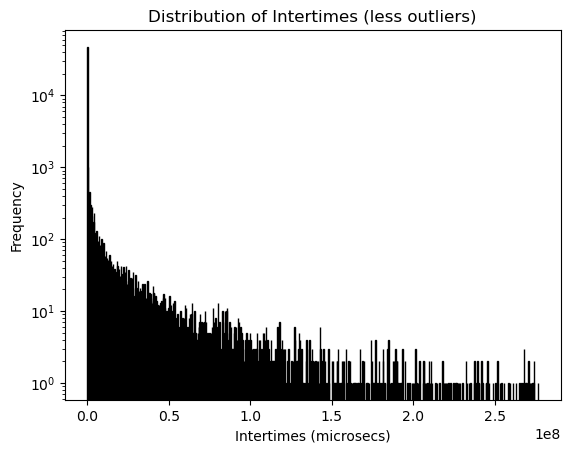

In [650]:
# Calculate the Z-scores of the series
z_scores = stats.zscore(sorted_df['intertimes'])

# Define a threshold for Z-scores to identify outliers (commonly 3 or -3)
z_score_threshold = 1

# Filter the series to remove outliers
filtered_series_zscore = sorted_df['intertimes'][(z_scores < z_score_threshold) & (z_scores > -z_score_threshold)]


# Plot the histogram
plt.hist(filtered_series_zscore, bins=1000, edgecolor='black')
plt.xlabel('Intertimes (microsecs)')
plt.ylabel('Frequency')
# Set y-axis to log scale
plt.yscale('log')

plt.title('Distribution of Intertimes (less outliers)')
plt.show()

# Grouping

In [651]:
# Identify columns with a single unique value
unique_value_columns = main_df.nunique() == 1

# Drop these columns
filtered_df = main_df.loc[:, ~unique_value_columns]

In [652]:
unique_value_columns[unique_value_columns].index.tolist()

['Flotta', 'Veicolo', 'Test']

In [653]:
len(filtered_df.columns)

166

In [654]:
agg_df = main_df.groupby(['Codice',
 'Nome',
 'Componente',
 'Descrizione']).agg({
    'Flotta': 'count',
    'Durata': 'mean'})

agg_df.columns = ['N_Events',
 'Mean_Duration']

agg_df.reset_index(inplace=True )

In [655]:
agg_sorted_df = agg_df.sort_values('N_Events')

In [656]:
agg_sorted_df[-20:]

,Codice,Nome,Componente,Descrizione,N_Events,Mean_Duration
437,151022,_HvOnBoardUnit_,T2_1Q4_IP,Alta tensione non presente in M1-T4,519,44.880597
59,021476,OP_DCMAINCNT_PREC_DC,CONV_TRAZ_M1,Apertura forz. contatt. Convert. Princip. DC,537,12.265537
536,ILCK_IR_T7_01,ILCK_IR_T7_01,T2_1Q2_IR,Cod 01. Mancanza tensione di linea su treno lo...,537,5.850129
568,ILCK_PROP_22M1,ILCK_PROP_22M1,MDS,Cod. 22 Manettino fuori coasting dopo taglio t...,551,8.270417
530,ILCK_IR_T2_01,ILCK_IR_T2_01,T2_1Q2_IR,Cod 01. Mancanza tensione di linea su treno lo...,566,5.868557
537,ILCK_IR_T7_40,ILCK_IR_T7_40,T2_1Q2_IR,Cod 40. Contattore 1Q1 non nello stato DC,568,5.281481
553,ILCK_PROP_12M8,ILCK_PROP_12M8,MDS,Cod. 12 Rilascio Porte Sinistre Attivo,606,163.729685
556,ILCK_PROP_14,ILCK_PROP_14,MDS,Cod. 14 Nessuna direzione impostata,688,299.049635
531,ILCK_IR_T2_40,ILCK_IR_T2_40,T2_1Q2_IR,Cod 40. Contattore 1Q1 non nello stato DC,704,5.309342
545,ILCK_PROP_05,ILCK_PROP_05,VEHICLE,Cod. 05 Taglio trazione da SSB attivo,716,1460.124444


# Exctracting some knowledge:

In [657]:
main_df = pd.read_csv('dataset.csv')
main_df = main_df.dropna(subset=['Posizione'])
main_df = main_df.dropna(subset=['Timestamp'])

main_df['Timestamp'] = pd.to_datetime(main_df['Timestamp'])
main_df = main_df.sort_values('Timestamp')

# Let's compute centroids of discrete locations:

In [658]:
geo_information = main_df.groupby('Posizione').agg({
'Latitudine':'mean',
'Longitudine': 'mean'}).transpose().to_dict()

## Let's compute approximate train speed:

In [659]:
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert coordinates to tuples
    coords1 = (lat1, lon1)
    coords2 = (lat2, lon2)

    # Calculate distance using geodesic distance
    distance = geodesic(coords1, coords2).km  # Meters

    return distance

In [660]:
main_df['time_diff'] = main_df['Timestamp'].diff()

# seconds
main_df['time_diff'] = main_df['time_diff'].apply(lambda x: \
                                          x.total_seconds()\
                                          + x.microseconds / 10**6)

# hours
main_df['time_diff'] = main_df['time_diff'] / 3600

In [661]:
approx_speeds = [np.nan] * len(main_df)

for i in trange(len(main_df) - 1):
    time_diff = main_df.iloc[i+1]['time_diff']
    
    if time_diff > 0.01:
        init_lat = main_df.iloc[i]['Latitudine']
        init_long = main_df.iloc[i]['Longitudine']

        dest_lat = main_df.iloc[i+1]['Latitudine']
        dest_long = main_df.iloc[i+1]['Longitudine']
        dist_km = calculate_distance(init_lat, init_long, dest_lat, dest_long)
    
        if dist_km > 0:
            approx_speeds[i] = dist_km / time_diff

main_df['approximate speed'] = approx_speeds

# some interpolation...
main_df['approximate speed'] = main_df['approximate speed'].interpolate(method='linear').bfill()

  0%|          | 0/55795 [00:00<?, ?it/s]

In [663]:
main_df['approximate speed'].describe()  # is this really a high speed train?

count    55796.000000
mean        50.482963
std         65.261109
min          0.001622
25%          0.486186
50%         13.525630
75%         92.860441
max        248.658929
Name: approximate speed, dtype: float64

# Autoregressing these data:

## Are there correlations between speed and diagnostic events in the brakes?

In [691]:
agg_df = main_df.groupby(['Codice',
 'Nome',
 'Componente',
 'Descrizione']).agg({
    'Flotta': 'count',
    'Durata': 'mean'})

agg_df.columns = ['N_Events',
 'Mean_Duration']

agg_df.reset_index(inplace=True )
agg_df = agg_df.sort_values('N_Events')

## exctranting the most typical event:

In [665]:
brake_anomalies = agg_df.loc[agg_df['Descrizione'].str.contains('fren')]

In [692]:
brake_anomalies[['Nome', 'Descrizione','N_Events']].values

array([['_BCUBpLeakFlt_', 'Rilevata perdita nella condotta freno', 2],
       ['_BpLeakFlt_',
        'Rilevata perdita condotta freno e direzione marcia non in posizione neutra',
        2],
       ['_ParkBrakePrSwHighFlt_',
        'Stato indebito alto pressostati freno staz. PFSA e PFSR del 9A08',
        3],
       ['_ParkBrakePrSwHighFlt_',
        'Stato indebito alto pressostati freno staz. PFSA e PFSR del 9A08',
        3],
       ['_ParkBrakePrSwHighFlt_',
        'Stato indebito alto pressostati freno staz. PFSA e PFSR del 9A08',
        3],
       ['_ParkBrakePrSwHighFlt_',
        'Stato indebito alto pressostati freno staz. PFSA e PFSR del 9A08',
        5],
       ['_BCUBpLeakFlt_', 'Rilevata perdita nella condotta freno', 11],
       ['_ManDbvIsol_',
        'Rubinetto RIM 9S30 chiuso (valvola freni macchinista isolata man.)',
        21],
       ['_ManDbvIsol_',
        'Rubinetto RIM 9S30 chiuso (valvola freni macchinista isolata man.)',
        38],
       ['_Ed1Low_'

In [696]:
emergency_brake_df = main_df.loc[main_df['Nome']== '9K48_Emg']
ert700_df = main_df.loc[main_df['Nome']=='ILCK_PROP_03']

# Step 1: Identify columns with all NaN values
columns_to_drop_ert700 = ert700_df.columns[ert700_df.isna().all()]
columns_to_drop_eb = emergency_brake_df.columns[emergency_brake_df.isna().all()]

ert700_df = ert700_df.drop(columns=columns_to_drop_ert700)
emergency_brake_df = emergency_brake_df.drop(columns=columns_to_drop_eb)

In [694]:
# Identify columns with a single unique value
unique_value_columns_ert = ert700_df.nunique() == 1
dict(ert700_df[unique_value_columns_ert[unique_value_columns_ert].index.tolist()].iloc[0])

{'Flotta': 'ETR700',
 'Veicolo': 'e700_4801',
 'Codice': 'ILCK_PROP_03',
 'Nome': 'ILCK_PROP_03',
 'Descrizione': 'Cod. 03 Comando di frenatura da manipolatore attivo',
 'Test': 'N',
 'Sistema': 'VEHICLE',
 'Componente': 'VEHICLE'}

In [700]:
unique_value_columns_eb = emergency_brake_df.nunique() == 1
dict(emergency_brake_df[unique_value_columns_eb[unique_value_columns_eb].index.tolist()].iloc[0])

{'Flotta': 'ETR700',
 'Veicolo': 'e700_4801',
 'Nome': '9K48_Emg',
 'Test': 'N',
 'Sistema': 'FRENO',
 'Componente': 'FRENO',
 'HMI_ACPntSts_T2': 0.0,
 'HMI_ACPntSts_T7': 0.0,
 'LineVoltType': 2.0,
 'MDS_LedLimVel': 0.0,
 'MDS_StatoMarcia': 1.0}

In [701]:
# Drop these columns
ert700_df = ert700_df.loc[:, ~unique_value_columns_ert]
emergency_break_df = emergency_brake_df.loc[:, ~unique_value_columns_eb]

In [702]:
ert700_df = ert700_df.sort_values('Timestamp')
emergency_brake_df = emergency_brake_df.sort_values('Timestamp')

## Seems the train is going from Milano to Trieste back and forth...

In [703]:
station_changes_df = ert700_df.loc[ert700_df['Posizione']!=ert700_df['Posizione'].shift(1)]

In [704]:
station_changes_df[28:35]

,Timestamp,Timestamp chiusura,Durata,Posizione,Latitudine,Longitudine,Contemporaneo,Timestamp segnale,CabEnabled_M1,CabEnabled_M8,...,usB2BCilPres_T2,usB2BCilPres_T4,usB2BCilPres_T5,usB2BCilPres_T7,usBpPres,usMpPres,time_diff,approximate speed,event_change,time_change
53805,2022-03-07 11:41:45.345,2022-03-07 11:42:03.756,19.0,Ruda,45.8125,13.4400,1,2022-03-07 11:41:45.345,0.0,1.0,...,0.00,0.01,0.0,0.01,4.89,8.72,0.002334,119.768237,True,True
53803,2022-03-07 11:42:52.347,2022-03-07 11:43:18.948,27.0,San Canzian d'Isonzo,45.8163,13.4676,1,2022-03-07 11:42:52.347,0.0,1.0,...,0.00,0.00,0.0,0.09,4.94,9.48,0.007277,69.031656,False,True
53802,2022-03-07 11:43:23.745,2022-03-07 11:44:09.349,46.0,Ronchi dei Legionari,45.8169,13.4771,1,2022-03-07 11:43:23.745,0.0,1.0,...,0.00,0.00,0.0,0.01,4.94,9.11,0.008832,43.663365,False,True
53673,2022-03-07 12:10:17.349,2022-03-07 12:10:20.35,4.0,Trieste,45.6700,13.7595,0,2022-03-07 12:10:15.544,0.0,1.0,...,0.00,0.00,0.0,0.00,4.95,8.49,0.000000,48.690263,False,False
52658,2022-03-07 17:23:30.007,2022-03-07 17:23:47.608,18.0,Doberdò del Lago,45.8038,13.5824,1,2022-03-07 17:23:30.007,1.0,0.0,...,0.02,0.00,0.0,0.00,4.95,8.83,0.000334,56.646537,True,True
52641,2022-03-07 17:26:26.206,2022-03-07 17:27:00.609,35.0,Ronchi dei Legionari,45.8061,13.5508,1,2022-03-07 17:26:26.206,1.0,0.0,...,0.00,0.00,0.0,0.01,4.90,8.61,0.005836,29.619637,True,True
52415,2022-03-07 17:40:08.204,2022-03-07 17:40:13.008,5.0,Ruda,45.8119,13.4023,1,2022-03-07 17:40:08.204,1.0,0.0,...,0.00,0.00,0.0,0.01,4.95,8.47,0.001113,88.622813,True,True


## Are brakes working?

we take records before and after this breaking command and see what happens to speed...

In [805]:
event_change = main_df['Nome'] != main_df['Nome'].shift(1)
main_df['event_change'] = event_change
time_change = main_df['Timestamp'] != main_df['Timestamp'].shift(1)
main_df['time_change'] = time_change

speed_df = main_df[['Timestamp', 'approximate speed', 'Nome', 'event_change', 'time_change']].copy()
speed_df = speed_df.reset_index()

In [806]:
time_change_df = speed_df.loc[speed_df['time_change']].copy().reset_index()
braking_df = speed_df.loc[speed_df['Nome']=='9K48_Emg'].copy()
event_change_df = speed_df.loc[speed_df['event_change']].copy()

In [807]:
prev_window_size = 10
post_window_size = 10
chunks = []

for index in tqdm(time_change_df.loc[time_change_df['Nome']=='9K48_Emg'].index):

    # Define start and end indices for the chunk
    start_index = max(0, index - prev_window_size)  # Ensure start doesn't go below 0
    end_index = min(time_change_df.index.max(), index + post_window_size + 1)  # Ensure end doesn't go beyond DataFrame length
    # Extract the chunk and append it to the list
    chunk = time_change_df.iloc[start_index:end_index].copy()
    chunk['braking'] = chunk['Nome'] == '9K48_Emg'

    if len(chunk) > 0:
        chunk['rel_time'] = chunk['Timestamp'] - chunk['Timestamp'].iloc[0]
        chunk['rel_time'] = pd.to_timedelta(chunk['rel_time']).apply(lambda x: \
                                              x.total_seconds() * 10**6 \
                                              + x.microseconds)
        chunk['rel_time'] = chunk['rel_time'] / 10**6

        chunks.append(chunk[['Timestamp','rel_time', 'approximate speed', 'braking']])

  0%|          | 0/59 [00:00<?, ?it/s]

In [808]:
def plot_brake_influence(current_chunk):

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 5))

    not_braking_points = current_chunk.loc[current_chunk['braking']==False]
    braking_points = current_chunk.loc[current_chunk['braking']==True]

    average_speed_by_time = (
        current_chunk.groupby('rel_time')['approximate speed'].mean()
    )

    # Plot the average speed line
    ax.plot(average_speed_by_time.index, average_speed_by_time.values, color='blue')

    # Plot vertical lines for braking times
    braking_times = current_chunk[current_chunk['braking'] == True]['rel_time']
    ax.vlines(braking_times, ymin=0, ymax=average_speed_by_time.max(), color='red', linestyle='--')


    # Label the axes
    ax.set_xlabel('Time (microsecs)')
    ax.set_ylabel('Speed (km/h)')

    # Add a title
    ax.set_title('Speed Over Time with Braking Indication')

    # Optional: Customize grid and legend
    ax.grid(True)
    # Uncomment to add a legend (if needed)
    # plt.legend()

    # Show the plot
    plt.show()


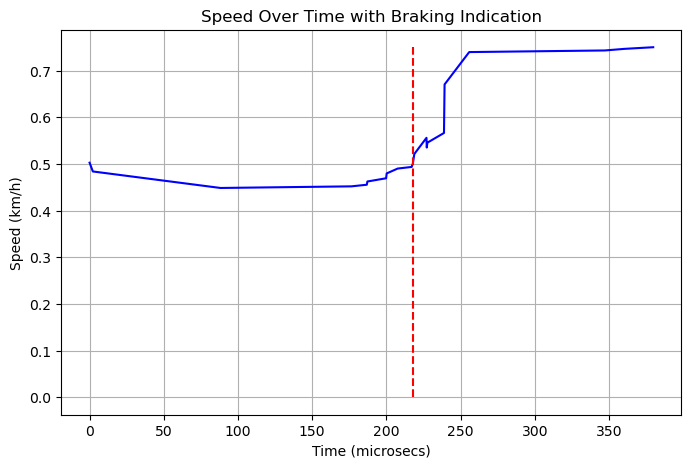

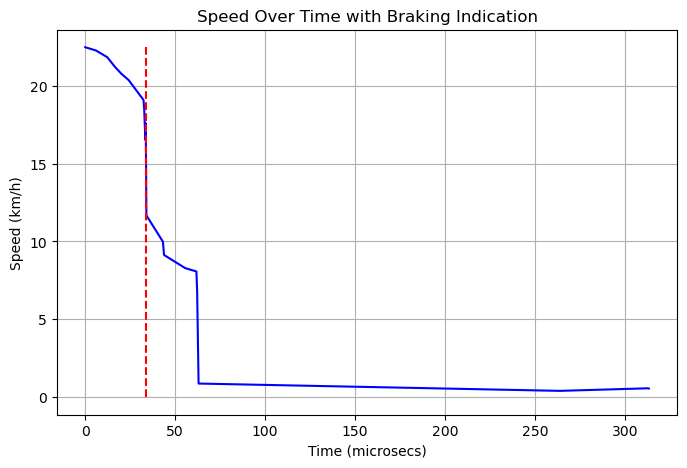

In [809]:
for current_chunk in chunks[2:4]:
    plot_brake_influence(current_chunk)

### Seems that something's wrong with the second pattern!

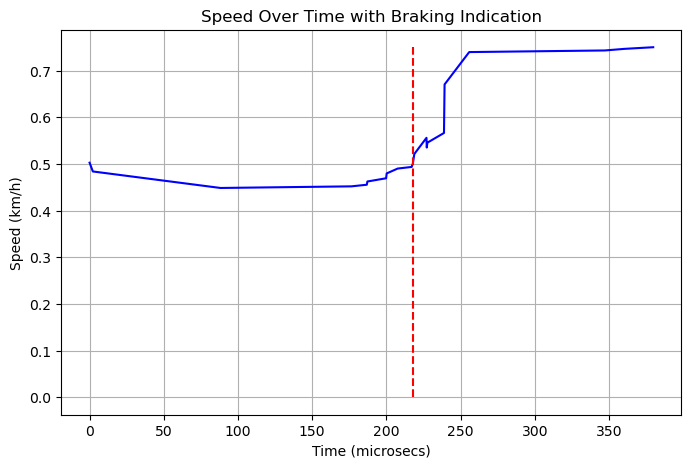

In [822]:
plot_brake_influence(chunks[2])

In [823]:
chunks[2]

,Timestamp,rel_time,approximate speed,braking
92,2022-03-07 06:48:53.137,0.000,0.502796,False
93,2022-03-07 06:48:54.739,2.204,0.483993,False
94,2022-03-07 06:50:20.744,88.214,0.448604,False
95,2022-03-07 06:51:49.339,176.404,0.452072,False
96,2022-03-07 06:51:59.541,186.808,0.455540,False
97,2022-03-07 06:51:59.739,187.204,0.462477,False
98,2022-03-07 06:52:12.546,199.818,0.469413,False
99,2022-03-07 06:52:12.744,200.214,0.479818,False
100,2022-03-07 06:52:19.940,207.606,0.490223,False
101,2022-03-07 06:52:30.141,217.008,0.493692,False


### Are there some suspicios signals around that time?

In [828]:
context_df = main_df.loc[
    (main_df['Timestamp']<pd.Timestamp('2022-03-07 06:52:45.143')) \
    & (main_df['Timestamp']>pd.Timestamp('2022-03-07 06:52:20.143')) ]

In [829]:
context_df['Descrizione'].unique()

array(['Cod. 03 Comando di frenatura da manipolatore attivo',
       'Frenatura di emergenza attivata da leva di frenatura in M1',
       'Cod. 18 Linea Emergenza Attiva',
       'Cod. 04 Condotta Generale scarica',
       'Cod. 14 Nessuna direzione impostata',
       'Apertura forz. contatt. Convert. Princip. DC'], dtype=object)

## What about the other brakes?

In [800]:
prev_window_size = 10
post_window_size = 10
chunks = []

for index in tqdm(time_change_df.loc[time_change_df['Nome']=='ILCK_PROP_03'].index):

    # Define start and end indices for the chunk
    start_index = max(0, index - prev_window_size)  # Ensure start doesn't go below 0
    end_index = min(time_change_df.index.max(), index + post_window_size + 1)  # Ensure end doesn't go beyond DataFrame length
    # Extract the chunk and append it to the list
    chunk = time_change_df.iloc[start_index:end_index].copy()
    chunk['braking'] = chunk['Nome'] == 'ILCK_PROP_03'

    if len(chunk) > 0:
        chunk['rel_time'] = chunk['Timestamp'] - chunk['Timestamp'].iloc[0]
        chunk['rel_time'] = pd.to_timedelta(chunk['rel_time']).apply(lambda x: \
                                              x.total_seconds() * 10**6 \
                                              + x.microseconds)
        chunk['rel_time'] = chunk['rel_time'] / 10**6

        chunks.append(chunk[['Timestamp','rel_time', 'approximate speed', 'braking']])

  0%|          | 0/1444 [00:00<?, ?it/s]

In [801]:
len(chunks)

1444

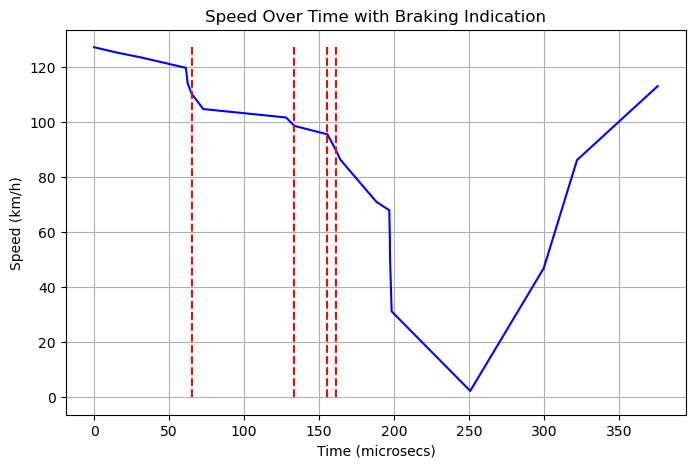

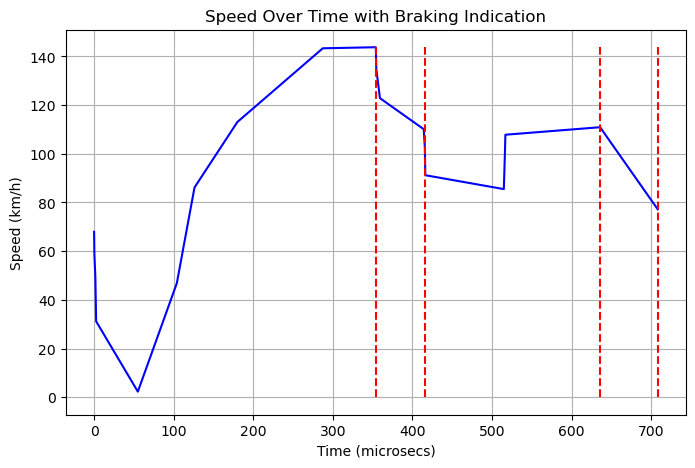

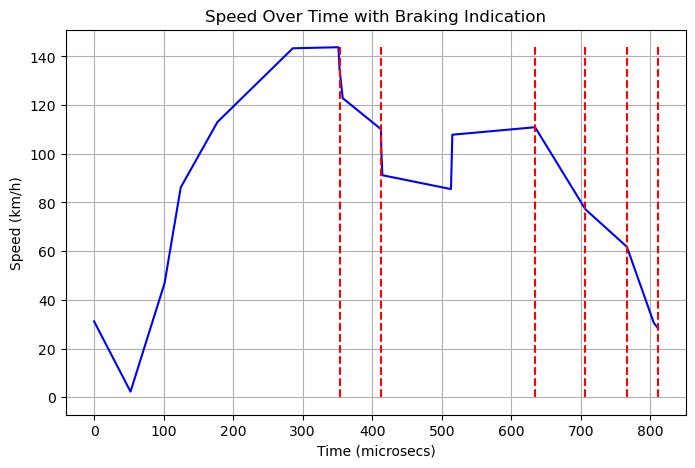

In [804]:
for current_chunk in chunks[33:36]:
    plot_brake_influence(current_chunk)